In [1]:
import math
import pickle
import random
import re
import time
import os
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as st

# cwd
os.chdir(r'/Users/guichengtong/Desktop/path-comparison/ns-3.40')

# print(os.getcwd())
# os.system("mkdir data")
# os.system("./ns3 clean")
# os.system("./ns3 configure")
# os.system("./ns3 build")
# print(os.getcwd())

In [2]:
# [MUST RUN] parsing

class EventType(Enum):
    ENQUEUE = 1
    SEND_OR_DEQUEUE = 2
    RECEIVE = 3

    
def get_span(matcher, txt):
    return txt[matcher.span()[0]:matcher.span()[1]]

def parse_info(line, link):
    event = None
    if line[0] == '+':
        event = EventType.ENQUEUE
    elif line[0] == '-':
        event = EventType.SEND_OR_DEQUEUE
    elif line[0] == 'r':
        event = EventType.RECEIVE

    time = float(line[1:].split()[0])
    length_matcher = re.search("(size=\d*)", line)
    if length_matcher is None:
        length = 0
    else:
        length = int(line[length_matcher.span()[0]+5:length_matcher.span()[1]])
    src_dest_matcher = re.search("\d*\.\d*\.\d*\.\d*\s[\>\<]\s\d*\.\d*\.\d*\.\d", line)
    src_dest_str = get_span(src_dest_matcher, line)
    seq_matcher = re.search("Seq=\d*", line)
    seq_no = int(line[seq_matcher.span()[0]+4:seq_matcher.span()[1]])
    id_matcher = re.search("id \d*", line)
    id_no = int(line[id_matcher.span()[0]+3:id_matcher.span()[1]])
    port_matcher = re.search("[0-9]{5} > [0-9]{5}", line)
    port = get_span(port_matcher, line)
    
    return {"link": link,
            "event": event, 
            "time": time, 
            "len":length,
            "src_dest":src_dest_str,
            "seq":seq_no,
            "id":id_no,
            "port":port}

def event_str(event):
    if event == EventType.ENQUEUE:
        return "Enqueue"
    elif event == EventType.SEND_OR_DEQUEUE:
        return "SEND"
    elif event == EventType.RECEIVE:
        return "RCV"
    else:
        return "ERROR"
    

def parse_link(host_node, int1, int2, events):
    # returns the link string
    filename = "traces/-{}-Int{}->{}.tr".format(host_node, int1, int2)

    f = open(filename, "r")
    link = "{}->{}".format(str(int1), str(int2))
    while True:
        line = f.readline()
        if len(line) == 0:
            break
        info = parse_info(line, link)
        events.append(info)

    return link

def read_logfile(logfile_name):
    f = open(logfile_name, "r")
    txt = ""
    while True:
        line = f.readline()
        if len(line) == 0:
            break
        txt += line
    
    results = parse_results_sync(txt)

    return results

def write_to_file(contents, file_name):
    print("writing to {}".format(file_name))
    f = open(file_name, "w")
    f.write(contents)
    f.close()

def parse_results_sync(txt):
    n_matcher = re.search("Synced \[(\d*)\]", txt)
    n = int(n_matcher.group(1))

    rtx_matcher = re.search("Total size of rtxs 1 \[(\d*)\] 2 \[(\d*)\]", txt)
    rtx1 = int(rtx_matcher.group(1))
    rtx2 = int(rtx_matcher.group(2))

    total_pkts_matcher = re.search("Total number of sent pkts 1 \[(\d*)\] 2 \[(\d*)\]", txt)
    total_pkts1 = int(total_pkts_matcher.group(1))
    total_pkts2 = int(total_pkts_matcher.group(2))

    lambda_matcher = re.search("Lambda 1 \[(\d*.?\d*)\] 2 \[(\d*.?\d*)\]", txt)
    lambda1 = float(lambda_matcher.group(1))
    lambda2 = float(lambda_matcher.group(2))

    time_matcher = re.search("Time \[(\d*.?\d*)\]", txt)

    phat1 = rtx1 / n
    phat2 = rtx2 / n
    
    return_dict = {
            "n":n, 
            "pkts1": total_pkts1,
            "pkts2": total_pkts2,
            "rtx1": rtx1, 
            "rtx2": rtx2, 
            "lambda1" : lambda1,
            "lambda2" : lambda2,
            "phat1": phat1, 
            "phat2": phat2}
    
    if time_matcher is not None:
        time = float(time_matcher.group(1))
        return_dict["time"] = time
    return return_dict


def parse_results_nosync(txt):
    n_matcher = re.search("No sync n 1 \[(\d*)\] 2 \[(\d*)\]", txt)
    n1 = int(n_matcher.group(1))
    n2 = int(n_matcher.group(2))

    rtx_matcher = re.search("No sync rtxs 1 \[(\d*)\] 2 \[(\d*)\]", txt)
    rtx1 = int(rtx_matcher.group(1))
    rtx2 = int(rtx_matcher.group(2))

    return_dict = {
        "n1" : n1,
        "n2" : n2,
        "rtx1" : rtx1,
        "rtx2" : rtx2
    }

    return return_dict

def run_test(throughput1, throughput2, link_loss1, link_loss2, delta, seconds, tcp_flows, loss_duration, targetZE=None):
    start = time.time()
    os.system("rm -rf traces")
    os.system("mkdir traces")
    seed = random.randrange(1, 2**31)
    args = "-srcThroughput1={}Mbps -srcThroughput2={}Mbps -throughput={}Mbps -linkLoss1={} -linkLoss2={} -stopTime={} -delta={} ".format(
        throughput1,
        throughput2, 
        throughput1+throughput2+10, 
        link_loss1,
        link_loss2,
        seconds,
        delta
    )

    args2 = "-seed={} -tcpFlows={} -lossDuration={}".format(
        seed,
        tcp_flows,
        loss_duration,
    )

    logs_configs = "t1{}Mbps-t2{}Mbps-t{}Mbps-l1{}-l2{}-time{}-delta{}-flows{}-lossDuration{}-seed{}".format(
        throughput1,
        throughput2, 
        throughput1+throughput2+10, 
        link_loss1,
        link_loss2,
        seconds,
        delta,
        tcp_flows,
        loss_duration,
        seed
    )

    if targetZE is not None:
        args2 +=  " -targetZE={}".format(targetZE)
        logs_configs += "-ze{}".format(targetZE)
    # logs_path += ".txt"
    os.system("./ns3 run scratch/sync-impl.cc -- {} {}> data/{}.txt 2>&1".format(args, args2, logs_configs))

    print("args: {} {}".format(args, args2))

    end = time.time()
    print("ran for ", end - start)
    return logs_configs


In [3]:
# [MUST RUN] define advice functions

def zscore_to_alpha(z):
    one_tail_alpha = st.norm.cdf(z)
    p = 1 - one_tail_alpha

    return 1 - (2 * p)

def alpha_to_zscore(alpha):
    p = 1 - alpha
    one_tail_alpha = 1 - (0.5 * p)

    return st.norm.ppf(one_tail_alpha)

def get_expected(l_1, l_2, Delta):
    exp_time = (l_1 + l_2) / (l_1 * l_2)

    if Delta <= exp_time/2:
        return_val = math.floor((1 / Delta) * (1- math.e ** (-Delta * l_1)) * (1 - math.e ** (-Delta * l_2))) 
    else:
        return_val = math.floor(1 / exp_time)

    return return_val

def advice_min_sync_needed(alpha, E, max_phat=0.5):
    # returns advice on the minimum number of packets needed to sync to achieve \alpha, E
    z = alpha_to_zscore(alpha)

    n = max_phat * (1 - max_phat) * pow(z, 2) / pow(E, 2)
    
    return n

def advice_run_test_time(alpha, E, l1, l2, d, max_phat=0.5):
    # returns time in seconds for minimum time to achieve \alpha, E given we have l1 = lambda_1, l2 = lambda_2, d
    exp_sync_per_sec = get_expected(l1, l2, d)
    min_sync_total = advice_min_sync_needed(alpha, E, max_phat)

    time_needed = min_sync_total / exp_sync_per_sec

    return time_needed

def advice_alpha(E, n, max_phat = 0.5):
    # returns advice on minimum confidence level for E, n

    min_zscore = math.sqrt(pow(E, 2) * n / (max_phat * (1 - max_phat)))

    return zscore_to_alpha(min_zscore)

def advice_precision(alpha, n):
    # returns maximum precision we can achieve for \alpha, n
    z = alpha_to_zscore(alpha)
    phat = 0.5

    E = z * math.sqrt((phat * (1 - phat) / n))

    return E

# print(advice_min_sync_needed(.98, 0.0001, max_phat=0.01))
# print(advice_run_test_time(.98, 0.0001, 10000, 10000, 0.001, 0.001))


In [4]:
# [MUST RUN] - use old data function
def parse_and_return(filename, parse_method, delete=False):
    f = open(filename, "r")
    txt = ""
    while True:
        line = f.readline()
        if len(line) == 0:
            break
        txt += line

    return_dict = None 
    
    try:
        return_dict = parse_method(txt)
    except AttributeError as ae:
        print("attribute error", ae)
        if delete:
            print("removing ", filename)
            os.system("rm " + filename)

    if return_dict is not None:
        return return_dict
    else:
        print("None", filename)
        if delete:
            print("removing ", filename)
            os.system("rm " + filename)

def get_seeds(file_pattern, directory):
    compiled_pattern = re.compile(file_pattern)
    seed_pattern = "-seed(\d+)"

    seeds = set()
    for f in os.listdir(directory):
        if compiled_pattern.match(f):
            seeds.add(re.search(seed_pattern, f).group(1))
    
    return seeds

def get_time_unbound_filenames(throughput1, throughput2, link_loss1, link_loss2, delta, tcp_flows, loss_duration, targetZE):
    directory = "data/"
    filename = "t1{}Mbps-t2{}Mbps-t{}Mbps-l1{}-l2{}-time\d*.?\d*-delta{}-flows{}-lossDuration{}-seed\d+-ze{}".format(
            throughput1,
            throughput2, 
            throughput1+throughput2+10, 
            link_loss1,
            link_loss2,
            delta,
            tcp_flows,
            loss_duration,
            targetZE
        )

    file_pattern = r'({}\.txt)'.format(filename)

    compiled_pattern = re.compile(file_pattern)

    files = []
    for f in os.listdir(directory):
        if compiled_pattern.match(f):
            files.append("{}{}".format(directory, f))
    
    return files
    
def get_sync_nosync_seeds(throughput1, throughput2, link_loss1, link_loss2, delta, seconds, tcp_flows, loss_duration):
    directory = "data/"
    filename = "t1{}Mbps-t2{}Mbps-t{}Mbps-l1{}-l2{}-time{}-delta{}-flows{}-lossDuration{}-seed\d+".format(
            throughput1,
            throughput2, 
            throughput1+throughput2+10, 
            link_loss1,
            link_loss2,
            seconds,
            delta,
            tcp_flows,
            loss_duration
        )


    nosync_filename = "nosync"+filename

    # Specify the regex pattern for filenames
    sync_pattern = r'({}\.txt)'.format(filename)  # Matches 'file' followed by one or more digits and '.txt'
    nosync_pattern = r'({}\.txt)'.format(nosync_filename)

    sync_seeds = get_seeds(sync_pattern, directory)
    nosync_seeds = get_seeds(nosync_pattern, directory)

    return list(sync_seeds.intersection(nosync_seeds))

def use_old_data(throughput1, throughput2, link_loss1, link_loss2, delta, seconds, tcp_flows, loss_duration, delete):
    seeds = get_sync_nosync_seeds(throughput1, throughput2, link_loss1, link_loss2, delta, seconds, tcp_flows, loss_duration)
    directory = "data/"
    file_name = "t1{}Mbps-t2{}Mbps-t{}Mbps-l1{}-l2{}-time{}-delta{}-flows{}-lossDuration{}".format(
                throughput1,
                throughput2, 
                throughput1+throughput2+10, 
                link_loss1,
                link_loss2,
                seconds,
                delta,
                tcp_flows,
                loss_duration
            )

    sync_data = []
    nosync_data = []

    for seed in seeds:
        sync_filename = "{}{}-seed{}.txt".format(directory, file_name, seed)
        nosync_filename = "{}nosync{}-seed{}.txt".format(directory, file_name, seed)

        return_dict = parse_and_return(sync_filename, parse_results_sync, delete)
        return_dict["configs"] = "{}-seed{}".format(file_name, seed)
        nosync_return_dict = parse_and_return(nosync_filename, parse_results_nosync, delete)
        if return_dict is not None and nosync_return_dict is not None:
            sync_data.append(return_dict)
            nosync_data.append(nosync_return_dict)

    return sync_data, nosync_data

def use_time_unbound_data(throughput1, throughput2, link_loss1, link_loss2, delta, tcp_flows, loss_duration, alpha, E, delete=False):
    ze = alpha_to_zscore(alpha) / E

    filenames = get_time_unbound_filenames(throughput1, throughput2, link_loss1, link_loss2, delta, tcp_flows, loss_duration, ze)
    data = []

    for f in filenames:
        # sync_filename = "{}{}-seed{}-ze{}.txt".format(directory, file_name, seed, ze)

        return_dict = parse_and_return(f, parse_results_sync, delete)

        if return_dict is not None:
            # return_dict["configs"] = f #"{}-seed{}-ze{}".format(file_name, seed, ze)
            data.append(return_dict)

    return data


In [5]:
# [MUST RUN] helper functions to count synchronised packets

class DefaultStrategy:
    # memory of 1, only sync if packets are within delta
    def __init__(self, sorted_events):
        self.events = sorted_events

    def count_sync(self, delta):
        sync_count = 0
        prev_e = None
        for e in self.events:
            if prev_e is None:
                prev_e = e
            
            else:
                # sync condition - e is of different stream within prev_e[time] + delta
                if e["src_dest"] != prev_e["src_dest"] and e["time"] <= prev_e["time"] + delta:
                    sync_count += 1
                    # print(sync_count)
                    prev_e = None
                # otherwise update prev event
                else:
                    prev_e = e
        
        return sync_count
    
    def count_rtx(self, delta, measure_expire):
        rtx_count = {}
        prev_e = None
        sync_active = False

        dest_to_lookout_rtx = {}

        for e in self.events:
            if e["src_dest"] not in dest_to_lookout_rtx.keys():
                dest_to_lookout_rtx[e["src_dest"]] = {}
                rtx_count[e["src_dest"]] = 0
                # print("added lookout rtx dict for ", e["src_dest"])

        for e in self.events:
            lookout_rtx = dest_to_lookout_rtx[e["src_dest"]]
            other_lookout_rtx = dest_to_lookout_rtx[[k for k in dest_to_lookout_rtx.keys() if k != e["src_dest"]][0]]
            port_seq = e["port"] +"|" +  str(e["seq"])

            # check for rtx
            if port_seq in lookout_rtx.keys() and e["time"] <= lookout_rtx[port_seq]:
                rtx_count[e["src_dest"]] += 1


            # rtx condition 
            if sync_active and e["src_dest"] != prev_e["src_dest"] and e["time"] <= prev_e["time"] + delta:
                lookout_rtx[port_seq] = e["time"] + measure_expire
                other_lookout_rtx[prev_e["port"] + "|" + str(prev_e["seq"])] = prev_e["time"] + measure_expire
                sync_active = False
            # otherwise update prev event
            else:
                prev_e = e
        return rtx_count
    
class NoSyncStrategy:
    def __init__(self, sorted_events):
        self.events = sorted_events
        self.flow_1_src_dest = "10.0.5.1 > 10.0.7.2"
        self.flow_2_src_dest = "10.0.6.1 > 10.0.7.2"


    def count_rtx(self, delta, measure_expire):
        rtx_count = {}

        dest_to_lookout_rtx = {}

        for e in self.events:
            if e["src_dest"] not in dest_to_lookout_rtx.keys():
                dest_to_lookout_rtx[e["src_dest"]] = {}
                rtx_count[e["src_dest"]] = 0
                # print("added lookout rtx dict for ", e["src_dest"])

        for e in self.events:
            lookout_rtx = dest_to_lookout_rtx[e["src_dest"]]
            port_seq = e["port"] +"|" +  str(e["seq"])
            if port_seq in lookout_rtx.keys() and e["time"] <= lookout_rtx[port_seq]:
                rtx_count[e["src_dest"]] += 1

            lookout_rtx[port_seq] = e["time"] + measure_expire
            
        return rtx_count
    
# return total number of packets that can be synced 
def count_sync(delta, strategy=DefaultStrategy):
    r3r2_events = []
    parse_link("Router2", "R2", "R3", r3r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events), key=lambda x: x["time"])))
        
    r4r2_events = []
    parse_link("Router2", "R2", "R4", r4r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r4r2_events), key=lambda x: x["time"])))

    events =  sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events + r4r2_events), key=lambda x: x["time"])
    counter = strategy(events).count_sync(delta)

    return counter

# return total number of packets sent
def count_total_pkts(flow):
    events = []
    if flow == 1:
        parse_link("Router2", "R2", "R3", events)
    elif flow == 2:
        parse_link("Router2", "R2", "R4", events)

    events = list(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, events))

    return len(events)

# return total number of rtxs
def count_rtxs(delta, measure_expire, strategy=DefaultStrategy):
    r3r2_events = []
    parse_link("Router2", "R2", "R3", r3r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events), key=lambda x: x["time"])))
        
    r4r2_events = []
    parse_link("Router2", "R2", "R4", r4r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r4r2_events), key=lambda x: x["time"])))

    events =  sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events + r4r2_events), key=lambda x: x["time"])
    counter_dict = strategy(events).count_rtx(delta, measure_expire)

    return counter_dict


In [6]:
# [MUST RUN] - confidence, precision, classic mode, time-unbound mode

def get_confidence(n, E, phat):
    # returns total packets on both paths
    z = math.sqrt(((E**2) * n) / (phat * (1 - phat)))

    # since we are two-tailed, we want to remove the -z score
    confidence = st.norm.cdf(z) - st.norm.cdf(-z)

    return confidence

def change_confidence(old_E, new_E, conf):
    z = alpha_to_zscore(conf)
    z = z * new_E / old_E

    new_conf = st.norm.cdf(z) - st.norm.cdf(-z)

    return new_conf

    # returns maximum precision we can achieve for \alpha, n

def get_precision(n, alpha, phat):
    z = alpha_to_zscore(alpha)

    E = z * math.sqrt((phat * (1 - phat) / n))

    return E

# classic mode - run test for fixed time and E or alpha
# returns [flow1, flow2]
def run_classic_mode (throughput1, throughput2, ll1, ll2, delta, seconds, tcp_flows, loss_duration=0, E=None, alpha=None):
    while True:
        try:
            logs_configs = run_test(throughput1, throughput2, ll1, ll2, delta, seconds, tcp_flows, loss_duration) 
            return_dict = read_logfile("data/{}.txt".format(logs_configs))
            return_dict["configs"] = logs_configs

            break 
        except:
            print("error, retrying with same time")

    # flow_1_src_dest = "10.0.5.1 > 10.0.7.2"
    # flow_2_src_dest = "10.0.6.1 > 10.0.7.2"

    n = return_dict["n"]
    rtx1 = return_dict["rtx1"]
    rtx2 = return_dict["rtx2"]
    phat1 = rtx1 / n
    phat2 = rtx2 / n

    if (E is not None) and (alpha is not None):
        print("INVALID ARGS: E AND alpha PROVIDED")
        raise Exception
    if (E is not None):
        return_dict["alpha1"] = get_confidence(n, E, phat1)
        return_dict["alpha2"] = get_confidence(n, E, phat2)
    if (alpha is not None):
        return_dict["E1"] = get_precision(n, alpha, phat1)
        return_dict["E2"] = get_precision(n, alpha, phat2)

    return return_dict

def time_unbound_mode (throughput1, throughput2,ll1, ll2, delta, seconds, tcp_flows, E, alpha, loss_duration=0, max_iter=10):
    iters = 0
    ze = alpha_to_zscore(alpha) / E
    while  iters < max_iter:
        iters += 1
        logs_configs = run_test(throughput1, throughput2, ll1, ll2, delta, seconds, tcp_flows, loss_duration, targetZE=ze)
        print("logspath is", logs_configs)
        return_dict = None
        
        try:
            return_dict = read_logfile("data/{}.txt".format(logs_configs))
            n = return_dict["n"]
            rtx1 = return_dict["rtx1"]
            rtx2 = return_dict["rtx2"]
            phat1 = rtx1 / n
            phat2 = rtx2 / n


            return_dict["alpha1"] = get_confidence(n, E, phat1)
            return_dict["alpha2"] = get_confidence(n, E, phat2)

            return_dict["E1"] = get_precision(n, alpha, phat1)
            return_dict["E2"] = get_precision(n, alpha, phat2)
            print("SUCCESS!")
            return return_dict
        except Exception as e:
            print("Exception ", e)
            seconds *= 2
            print("except, retrying with ", seconds)

            continue

In [25]:
# [MUST RUN] get data fn for experiment for sync vs no sync
def get_data(ll1, ll2, runs, loss_duration, tcp_flows = 30, throughputs = [i for i in range(20, 101, 10)], make_data=False):
    acc1_plot = []
    acc2_plot = []

    nosync_acc1_plot = []
    nosync_acc2_plot = []

    # flow 1 - flow 2
    sync_diff_plot=[]
    nosync_diff_plot=[]
    for t in throughputs:
        acc1s = []
        acc2s = []
        
        nosync_acc1s = []
        nosync_acc2s = []

        sync_diffs = []
        nosync_diffs = []

        if not make_data:
            sync_data, nosync_data = use_old_data(20, t, ll1, ll2, 0.01, 40, tcp_flows, loss_duration, False)

        for j in range(max(runs, len(sync_data))):
            if (make_data) or len(sync_data) <= j:
                return_dict = run_classic_mode(20, t, ll1, ll2, 0.01, 40, tcp_flows, loss_duration=loss_duration, E=prec)
                nosync_rtxs = count_rtxs(None, 30, strategy=NoSyncStrategy)
                nosync_rtx1 = nosync_rtxs["10.0.5.1 > 10.0.7.2"]
                nosync_rtx2 = nosync_rtxs["10.0.6.1 > 10.0.7.2"]
                write_to_file("No sync rtxs 1 [{}] 2 [{}]\nNo sync n 1 [{}] 2 [{}]".format(nosync_rtx1, nosync_rtx2, return_dict["pkts1"], return_dict["pkts2"]), "data/nosync{}.txt".format(return_dict["configs"]))
            else:
                return_dict = sync_data[j]
                nosync_rtx1 = nosync_data[j]["rtx1"]
                nosync_rtx2 = nosync_data[j]["rtx2"]

            sync_phat1 = return_dict["phat1"]
            sync_phat2 = return_dict["phat2"]
            nosync_phat1 = nosync_rtx1/return_dict["pkts1"]
            nosync_phat2 = nosync_rtx2/return_dict["pkts2"]


            acc1s.append(sync_phat1 )
            acc2s.append(sync_phat2 )

            nosync_acc1s.append(nosync_phat1)
            nosync_acc2s.append(nosync_phat2)

            sync_diffs.append(sync_phat1 - sync_phat2)
            nosync_diffs.append(nosync_phat1 - nosync_phat2)

        acc1_plot.append(np.average(acc1s) * 100)
        acc2_plot.append(np.average(acc2s) * 100)

        nosync_acc1_plot.append(np.average(nosync_acc1s) * 100)
        nosync_acc2_plot.append(np.average(nosync_acc2s) * 100)

        sync_diff_plot.append(np.average(sync_diffs) * 100)
        nosync_diff_plot.append(np.average(nosync_diffs) * 100)

    return (acc1_plot, acc2_plot, nosync_acc1_plot, nosync_acc2_plot, sync_diff_plot, nosync_diff_plot)


In [22]:
# [DEFAULT PARAMETERS]
ll1 = 0.01
ll2 = 0.02
delta= 0.01
prec = 0.001
runs = 50
throughputs = [i for i in range(20, 101, 10)]


OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50
OLD DATA LEN 50 50


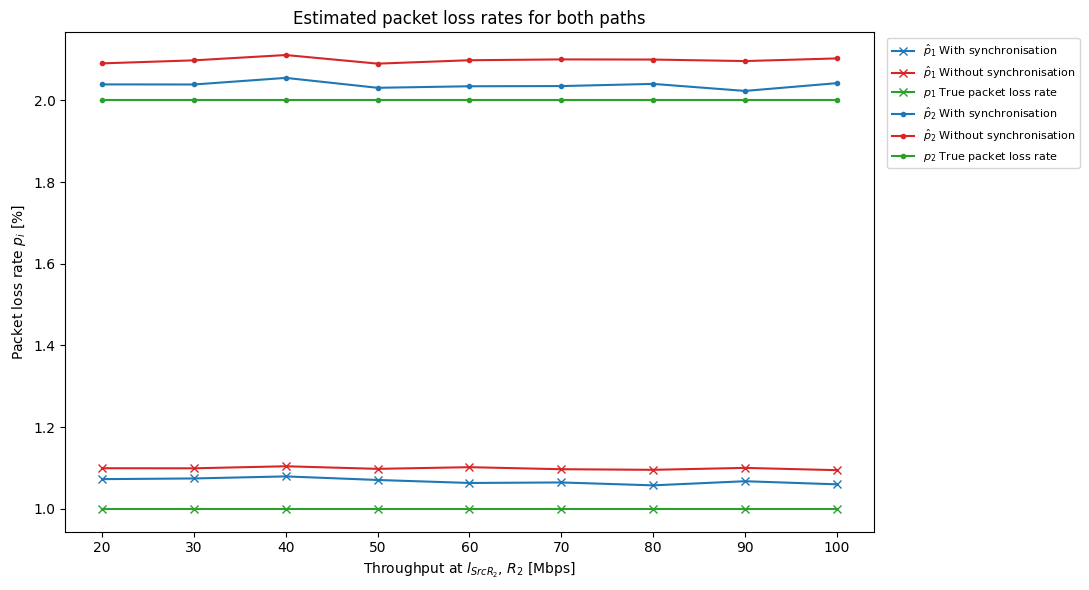

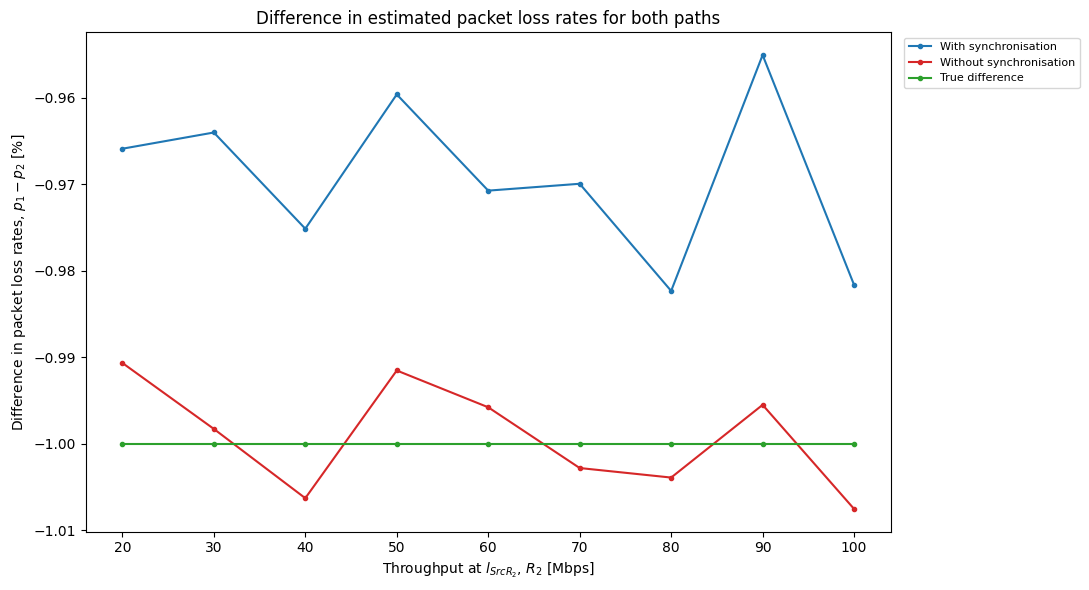

In [24]:
# [PLOT] results of sync vs no sync

ll1 = 0.01
ll2 = 0.02
acc1_plot, acc2_plot, nosync_acc1_plot, nosync_acc2_plot, sync_diff_plot, nosync_diff_plot = get_data(ll1, ll2, runs=0, loss_duration=0.5, tcp_flows=20)

plt.figure(figsize=(11, 6))
plt.title("Estimated packet loss rates for both paths")
plt.xlabel("Throughput at $l_{SrcR_2}$, $R_2$ [Mbps]")
plt.ylabel("Packet loss rate $p_i$ [%]")

plt.plot(throughputs, acc1_plot, label="$\\hat{p}_1$ With synchronisation", marker="x", color="tab:blue")
plt.plot(throughputs, nosync_acc1_plot, label="$\\hat{p}_1$ Without synchronisation", marker="x", color="tab:red")
plt.plot(throughputs, [ll1 * 100 for  _ in throughputs], label="$p_1$ True packet loss rate", marker="x", color="tab:green")

plt.plot(throughputs, acc2_plot, label="$\\hat{p}_2$ With synchronisation", marker=".", color="tab:blue")
plt.plot(throughputs, nosync_acc2_plot, label="$\\hat{p}_2$ Without synchronisation", marker=".", color="tab:red")
plt.plot(throughputs, [ll2 * 100 for _ in throughputs], label="$p_2$ True packet loss rate", marker=".", color="tab:green")

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), prop={'size': 8})
plt.tight_layout()


plt.figure(figsize=(11, 6))
plt.title("Difference in estimated packet loss rates for both paths")
plt.xlabel("Throughput at $l_{SrcR_2}$, $R_2$ [Mbps]")
plt.ylabel("Difference in packet loss rates, $p_1 - p_2$ [%]")

true_diff = ll1 - ll2

plt.plot(throughputs, sync_diff_plot, label="With synchronisation", marker=".", color="tab:blue")
plt.plot(throughputs, nosync_diff_plot, label="Without synchronisation", marker=".", color="tab:red")
plt.plot(throughputs, [true_diff * 100 for _ in throughputs], label="True difference", marker=".", color="tab:green")


plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), prop={'size': 8})
plt.tight_layout()




In [14]:
# [ANALYSIS]

ll1 = 0.5
ll2 = 0.5
prec = 0.001

def get_nosync_rtx_times(measure_expire):
    r3r2_events = []
    parse_link("Router2", "R2", "R3", r3r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events), key=lambda x: x["time"])))
        
    r4r2_events = []
    parse_link("Router2", "R2", "R4", r4r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r4r2_events), key=lambda x: x["time"])))
    sorted_events =  sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events + r4r2_events), key=lambda x: x["time"])

    rtx_count = {}
    total_pkt_count = {}
    dest_to_lookout_rtx = {}

    pkt_count = {}

    for e in sorted_events:
        if e["src_dest"] not in dest_to_lookout_rtx.keys():
            dest_to_lookout_rtx[e["src_dest"]] = {}
            total_pkt_count[e["src_dest"]] = 0

            rtx_count[e["src_dest"]] = []
            pkt_count[e["src_dest"]] = []
            # print("added lookout rtx dict for ", e["src_dest"])

    for e in sorted_events:
        total_pkt_count[e["src_dest"]] += 1
        lookout_rtx = dest_to_lookout_rtx[e["src_dest"]]
        port_seq = e["port"] +"|" +  str(e["seq"])
        if port_seq in lookout_rtx.keys() and e["time"] <= lookout_rtx[port_seq]:
            rtx_count[e["src_dest"]].append(e["time"])
            pkt_count[e["src_dest"]].append(total_pkt_count[e["src_dest"]])

        lookout_rtx[port_seq] = e["time"] + measure_expire
        
    # key is flow string, value is time that rtx occured for that flow
    # key is flow string, value is number of pkts at that time for that flow
    return rtx_count, pkt_count

def get_pkt_times():
    r3r2_events = []
    parse_link("Router2", "R2", "R3", r3r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events), key=lambda x: x["time"])))
        
    r4r2_events = []
    parse_link("Router2", "R2", "R4", r4r2_events)
    # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r4r2_events), key=lambda x: x["time"])))
    sorted_events =  sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events + r4r2_events), key=lambda x: x["time"])
    pkt_times = {}

    for e in sorted_events:
        if e["src_dest"] not in pkt_times.keys():
            pkt_times[e["src_dest"]] = []

    for e in sorted_events:
        pkt_times[e["src_dest"]].append(e["time"])

    return pkt_times

def get_sync_rtx_times(delta, measure_expire): 
        r3r2_events = []
        parse_link("Router2", "R2", "R3", r3r2_events)
        # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events), key=lambda x: x["time"])))
            
        r4r2_events = []
        parse_link("Router2", "R2", "R4", r4r2_events)
        # print(len(sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r4r2_events), key=lambda x: x["time"])))
        sorted_events =  sorted(filter(lambda x: x["event"] == EventType.SEND_OR_DEQUEUE, r3r2_events + r4r2_events), key=lambda x: x["time"])

        prev_e = None
        sync_active = False
        sync_counter = 0

        dest_to_rtx_count = {}
        dest_to_lookout_rtx = {}
        dest_to_sync = {}

        for e in sorted_events:
            if e["src_dest"] not in dest_to_lookout_rtx.keys():
                dest_to_lookout_rtx[e["src_dest"]] = {}
                dest_to_rtx_count[e["src_dest"]] = []
                dest_to_sync[e["src_dest"]] = []
                # print("added lookout rtx dict for ", e["src_dest"])

        for e in sorted_events:
            lookout_rtx = dest_to_lookout_rtx[e["src_dest"]]
            other_lookout_rtx = dest_to_lookout_rtx[[k for k in dest_to_lookout_rtx.keys() if k != e["src_dest"]][0]]
            port_seq = e["port"] +"|" +  str(e["seq"])

            # check for rtx
            if port_seq in lookout_rtx.keys() and e["time"] <= lookout_rtx[port_seq]:
                dest_to_rtx_count[e["src_dest"]].append(e["time"])
                dest_to_sync[e["src_dest"]].append(sync_counter)

            # rtx condition 
            if sync_active and e["src_dest"] != prev_e["src_dest"] and e["time"] <= prev_e["time"] + delta:
                sync_counter += 1
                lookout_rtx[port_seq] = e["time"] + measure_expire
                other_lookout_rtx[prev_e["port"] + "|" + str(prev_e["seq"])] = prev_e["time"] + measure_expire
                sync_active = False
            # otherwise update prev event
            else:
                sync_active = True
                prev_e = e

        
        # key is flow string, value is time that rtx occured for that flow
        # key is flow string, value is number of syncs at that time
        return dest_to_rtx_count, dest_to_sync




return_dict = run_classic_mode(20, 20, ll1, ll2, 0.01, 40, tcp_flows=20, loss_duration=10, E=prec)



In [12]:
# [ANALYSIS] - helper functions
def filter_times(start_time, end_time, pkt_times):
    f = []
    for t in pkt_times:
        if t > start_time and t <= end_time:
            f.append(t)

    return f


def filter_n_by_times(start_time, end_time, pkt_n, pkt_times):
    f = []
    for i in range(len(pkt_times)):
        t = pkt_times[i]
        if t > start_time and t <= end_time:
            f.append(pkt_n[i])

    return f

def get_last_count(time, pkt_times):
    counter = 0
    for t in pkt_times:
        if t > time:
            return counter
        counter += 1
    
    return counter

16245
34730


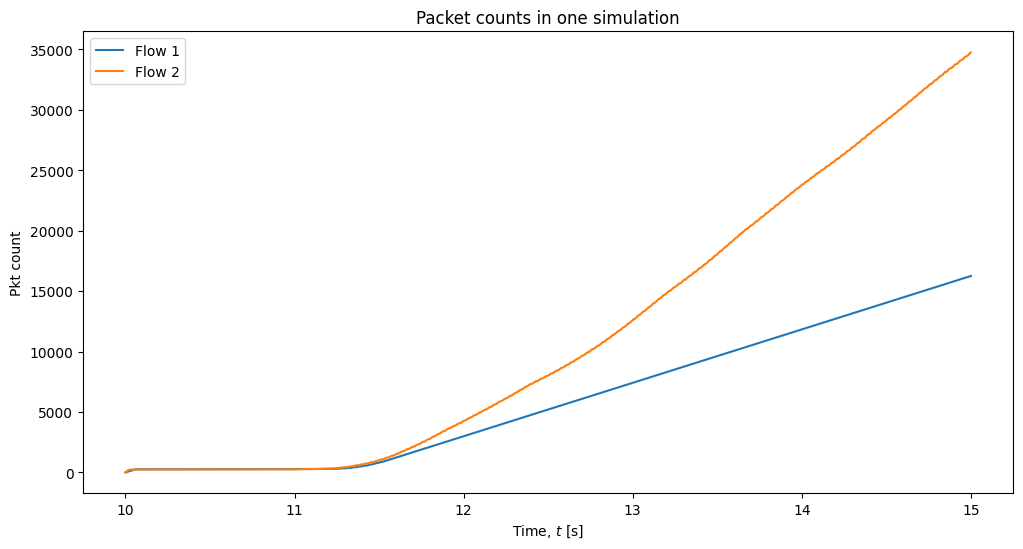

In [210]:
# [ANLAYSIS] - of packet counts in simulation
pkt_times = get_pkt_times()

pkt_1_times = pkt_times["10.0.5.1 > 10.0.7.2"]
pkt_2_times = pkt_times["10.0.6.1 > 10.0.7.2"]

start_time = 10
end_time = start_time + 5
    
f1 = filter_times(start_time, end_time, pkt_1_times)
f2 = filter_times(start_time, end_time, pkt_2_times)

plt.figure(figsize=(12, 6))
plt.title("Packet counts in one simulation")

plt.ylabel("Pkt count")
plt.xlabel("Time, $t$ [s]")

print(len(f1))
print(len(f2))

plt.plot(f1, [(i+1) for i in range(len(f1))], label="Flow 1")
plt.plot(f2, [(i+1) for i in range(len(f2))], label="Flow 2")

plt.legend()



In [17]:
# [ANALYSIS] - of r_i, n_i counts 
nosync_times, nosync_n = get_nosync_rtx_times(30)
sync_times, sync_n = get_sync_rtx_times(0.01, 2)

nosync_1_times = nosync_times["10.0.5.1 > 10.0.7.2"]
nosync_1_n = nosync_n["10.0.5.1 > 10.0.7.2"]
nosync_2_times = nosync_times["10.0.6.1 > 10.0.7.2"]
nosync_2_n = nosync_n["10.0.6.1 > 10.0.7.2"]

sync_1_times = sync_times["10.0.5.1 > 10.0.7.2"]
sync_1_n = sync_n["10.0.5.1 > 10.0.7.2"]
sync_2_times = sync_times["10.0.6.1 > 10.0.7.2"]
sync_2_n = sync_n["10.0.6.1 > 10.0.7.2"]

f1s = []
f2s = []

ns = []

nof1s = []
nof2s = []

n1s = []
n2s = []

# for t in [0, 5, 15, 20, 25, 30, 35]:
for t in [0]:
# for t in [10]:
    start_time = t
    end_time = start_time + 40
    
    f1n = filter_n_by_times(start_time, end_time, sync_1_n, sync_1_times)
    f2n = filter_n_by_times(start_time, end_time, sync_2_n, sync_2_times)

    ns.append(max(f1n[-1] - f1n[0], f2n[-1] - f2n[0]))

    f1 = filter_times(start_time, end_time, sync_1_times)
    nof1 = filter_times(start_time, end_time, nosync_1_times)
    f2 = filter_times(start_time, end_time, sync_2_times)
    nof2 = filter_times(start_time, end_time, nosync_2_times)

    n1 = filter_times(start_time, end_time, pkt_1_times)
    n2 = filter_times(start_time, end_time, pkt_2_times)

    f1s.append(len(f1))
    f2s.append(len(f2))
    nof1s.append(len(nof1))
    nof2s.append(len(nof2))

    n1s.append(len(n1))
    n2s.append(len(n2))

print(np.mean(f1s))
print(np.mean(f2s))
print(np.mean(nof1s))
print(np.mean(nof2s))
print(np.mean(n1s))
print(np.mean(n2s))

print("sync phat 1 [{}]".format(np.sum(f1s) / np.sum(ns)))
print("sync phat 2 [{}]".format(np.sum(f2s) / np.sum(ns)))
print("diff [{}]".format(np.sum(f1s) / np.sum(ns) - np.sum(f2s) / np.sum(ns)))
print("nosync phat 1 [{}]".format(np.sum(nof1s) / np.sum(n1s)))
print("nosync phat 2 [{}]".format(np.sum(nof2s) / np.sum(n2s)))


402.0
748.0
1247.0
1579.0
101218.0
69157.0
 402 & 36366 & 748 & 36366 \\ \hline
 1247 & 101218 & 1579 & 69157 \\ \hline
sync phat 1 [0.01105428147170434]
sync phat 2 [0.0205686630369026]
diff [-0.00951438156519826]
nosync phat 1 [0.01231994309312573]
nosync phat 2 [0.022832106655869978]


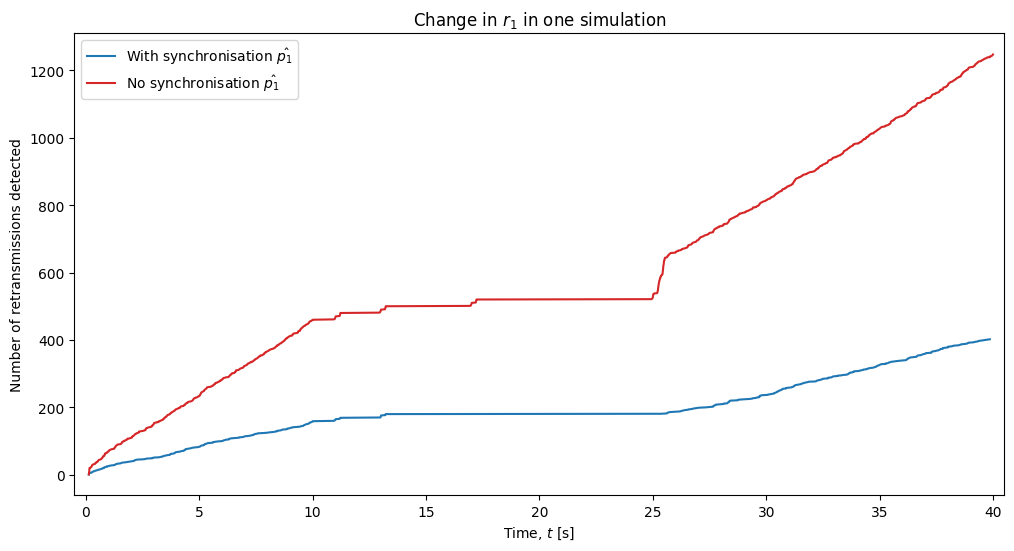

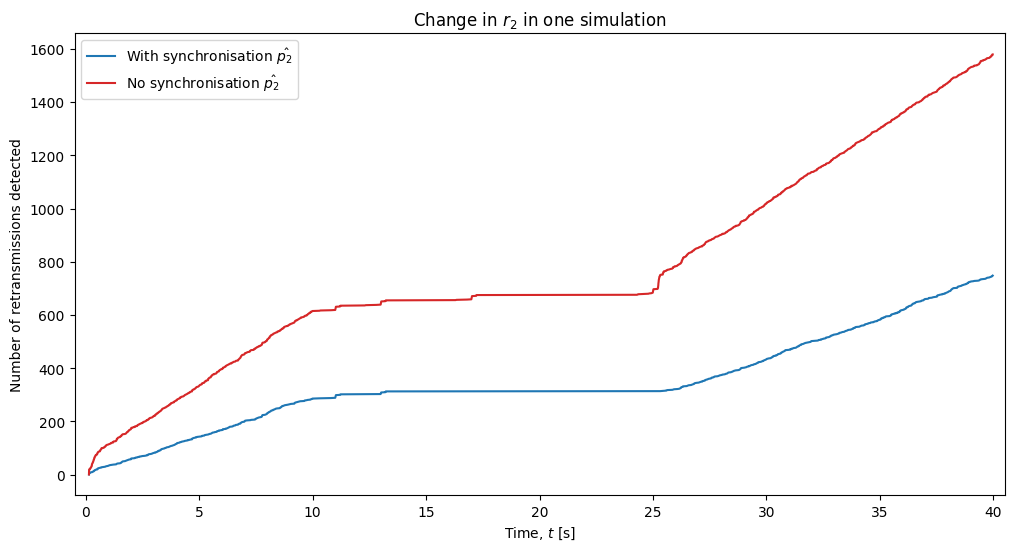

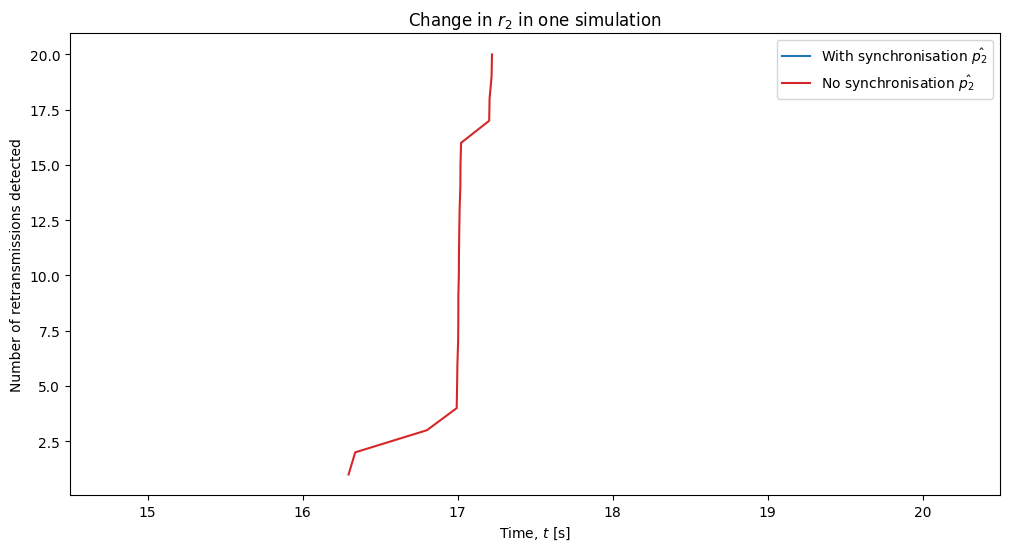

In [16]:
# [ANALYSIS] - of change in r_i over simulation

start_time = 0
end_time = start_time + 40
f1 = filter_times(start_time, end_time, sync_1_times)
nof1 = filter_times(start_time, end_time, nosync_1_times)
f2 = filter_times(start_time, end_time, sync_2_times)
nof2 = filter_times(start_time, end_time, nosync_2_times)

plt.figure(figsize=(12, 6))
plt.title("Change in $r_1$ in one simulation")
plt.ylabel("Number of retransmissions detected")
plt.xlabel("Time, $t$ [s]")

# plt.ylim(top=ll1 * 1.2, bottom = ll1 * 0.8)
plt.xlim(left = start_time - 0.5, right = end_time + 0.5)
plt.plot(f1, [(i + 1) for i in range(len(f1))], label="With synchronisation $\\hat{p_1}$",  color="tab:blue")
plt.plot(nof1, [(i + 1) for i in range(len(nof1))], label="No synchronisation $\\hat{p_1}$",  color="tab:red")
# plt.plot([i for i in range(1, 42)], [ll1 for _ in range(1, 42)], color="tab:green", marker=".", label="True $p_1$")
plt.legend()

plt.figure(figsize=(12, 6))
plt.title("Change in $r_2$ in one simulation")
plt.ylabel("Number of retransmissions detected")

plt.xlabel("Time, $t$ [s]")
plt.xlim(left = start_time - 0.5, right = end_time + 0.5)

plt.plot(f2, [(i + 1) for i in range(len(f2))], label="With synchronisation $\\hat{p_2}$", color="tab:blue")
plt.plot(nof2, [(i + 1) for i in range(len(nof2))], label="No synchronisation $\\hat{p_2}$", color="tab:red")
# plt.plot([i for i in range(1, 42)], [ll2 for _ in range(1, 42)], color="tab:green", marker=".", label="True $p_2$")

plt.legend()


start_time = 15
end_time = start_time + 5
f2 = filter_times(start_time, end_time, sync_2_times)
nof2 = filter_times(start_time, end_time, nosync_2_times)
plt.figure(figsize=(12, 6))
plt.title("Change in $r_2$ in one simulation")
plt.ylabel("Number of retransmissions detected")

plt.xlabel("Time, $t$ [s]")
plt.xlim(left = start_time - 0.5, right = end_time + 0.5)
# plt.ylim(top=ll2 * 1.2, bottom = ll2 * 0.8)
plt.plot(f2, [(i + 1) for i in range(len(f2))], label="With synchronisation $\\hat{p_2}$", color="tab:blue")
plt.plot(nof2, [(i + 1) for i in range(len(nof2))], label="No synchronisation $\\hat{p_2}$", color="tab:red")
# plt.plot([i for i in range(1, 42)], [ll2 for _ in range(1, 42)], color="tab:green", marker=".", label="True $p_2$")

plt.legend()

[0.136399, 0.13874, 0.14097, 0.143311, 0.145541, 0.147835, 0.150112, 0.152453, 0.234649, 0.269252, 0.274891, 0.2815, 0.360486, 0.436767, 0.464408, 0.498122, 0.52212, 0.537063, 0.547251, 0.571475, 0.581437, 0.619472, 0.631471, 0.75418, 0.773877, 0.889115, 0.950695, 1.01024, 1.04058, 1.04193, 1.04307, 1.20698, 1.21015, 1.2183, 1.24569, 1.36595, 1.38946, 1.42319, 1.43972, 1.45448, 1.45625, 1.58176, 1.75107, 2.10494, 2.22878, 2.27293, 2.32727, 2.35013, 2.35602, 2.46447, 2.48869, 2.5202, 2.57952, 2.6423, 2.81656, 2.82702, 2.90689, 2.91957, 2.9207, 2.94153, 3.12942, 3.14187, 3.1471, 3.16159, 3.16685, 3.20256, 3.21728, 3.24467, 3.2739, 3.2949, 3.40341, 3.41876, 3.42875, 3.45156, 3.5043, 3.51479, 3.52206, 3.5334, 3.58761, 3.64816, 3.67561, 3.70748, 3.70925, 3.78539, 3.8197, 3.82604, 3.87659, 3.95072, 4.03976, 4.05517, 4.07218, 4.16205, 4.16273, 4.20715, 4.21581, 4.23579, 4.27692, 4.28187, 4.30318, 4.31447, 4.37525, 4.37709, 4.56145, 4.56167, 4.66265, 4.66476, 4.69234, 4.74228, 4.87426, 4.89082

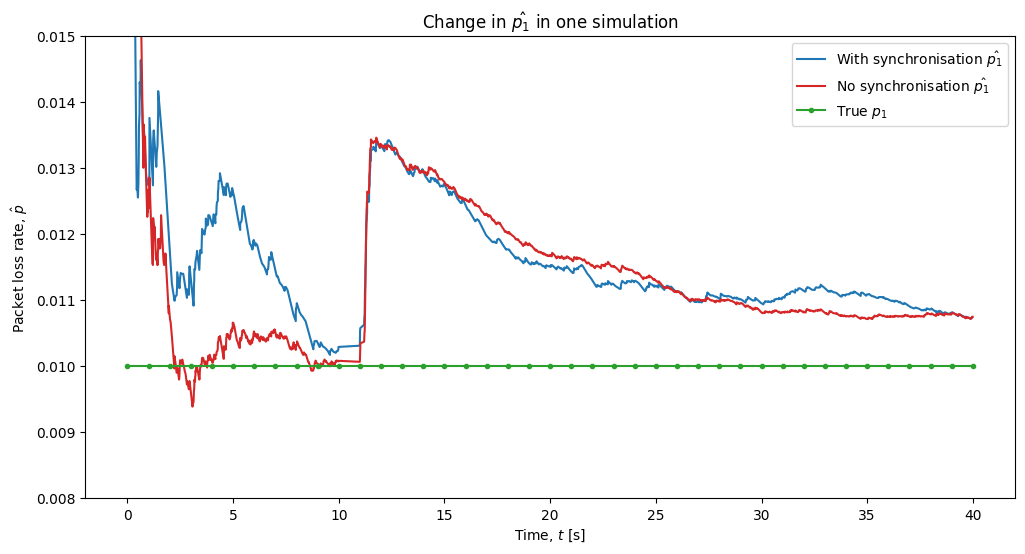

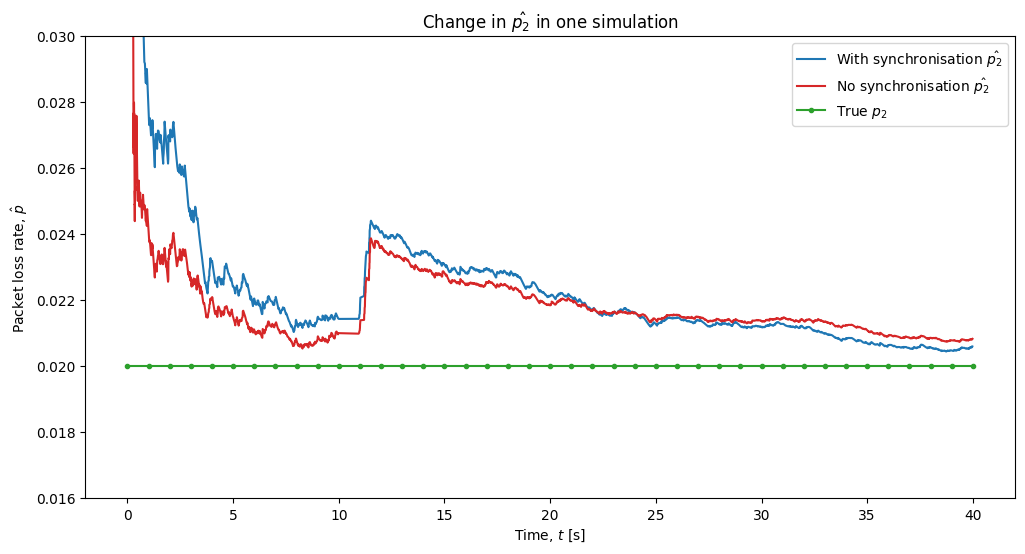

In [89]:
# [ANALYSIS] - of p_i over simulation
start_time = 0
end_time = start_time + 40

start1 = len(filter_times(0, start_time, sync_1_times)) + 1
f1 = filter_times(start_time, end_time, sync_1_times)
f1n = filter_n_by_times(start_time, end_time, sync_1_n, sync_1_times)

print(f1)
print(f1n)

no_start2 = len(filter_times(0, start_time, nosync_1_times)) + 1
no_f1 = filter_times(start_time, end_time, nosync_1_times)
no_f1n = filter_n_by_times(start_time, end_time, nosync_1_n, nosync_1_times)

start2 = len(filter_times(0, start_time, sync_2_times)) + 1
f2 = filter_times(start_time, end_time, sync_2_times)
f2n = filter_n_by_times(start_time, end_time, sync_2_n, sync_2_times)

no_start1 = len(filter_times(0, start_time, sync_2_times)) + 1
no_f2 = filter_times(start_time, end_time, nosync_2_times)
no_f2n = filter_n_by_times(start_time, end_time, nosync_2_n, nosync_2_times)

plt.figure(figsize=(12, 6))
plt.title("Change in $\\hat{p_1}$ in one simulation")
plt.ylabel("Packet loss rate, $\\hat{p}$")
plt.xlabel("Time, $t$ [s]")

plt.ylim(top=ll1 * 1.5, bottom = ll1 * 0.8)
plt.plot(f1, [(i + start1)/f1n[i] for i in range(len(f1))], label="With synchronisation $\\hat{p_1}$",  color="tab:blue")
plt.plot(no_f1, [(i + no_start1)/no_f1n[i] for i in range(len(no_f1))], label="No synchronisation $\\hat{p_1}$",  color="tab:red")
plt.plot([i for i in range(start_time, end_time + 1)], [ll1 for _ in range(start_time, end_time + 1)], color="tab:green", marker=".", label="True $p_1$")
plt.legend()

plt.figure(figsize=(12, 6))
plt.title("Change in $\\hat{p_2}$ in one simulation")
plt.ylabel("Packet loss rate, $\\hat{p}$")
plt.xlabel("Time, $t$ [s]")

plt.ylim(top=ll2 * 1.5, bottom = ll2 * 0.8)
plt.plot(f2, [(i + start2)/f2n[i]for i in range(len(f2))], label="With synchronisation $\\hat{p_2}$", color="tab:blue")
plt.plot(no_f2, [(i + no_start2)/no_f2n[i] for i in range(len(no_f2))], label="No synchronisation $\\hat{p_2}$", color="tab:red")
plt.plot([i for i in range(start_time, end_time + 1)], [ll2 for _ in range(start_time, end_time + 1)], color="tab:green", marker=".", label="True $p_2$")

plt.legend()

In [11]:
# [EXPERIMENT] [FINAL SETTINGS] - vary traffic pattern and which packets lost, check that results do not vary too much

con1s = []
con2s = []

phat1s = []
phat2s = []

ll1 = 0.01
ll2 = 0.02

prec= ll1 / 10

sync_data, nosync_data = use_old_data(20, 20, ll1, ll2, 0.01, 40, tcp_flows=20, loss_duration=0, delete=False)

for results in sync_data:
    n = results["n"]
    rtx1 = results["rtx1"]
    rtx2 = results["rtx2"]
    phat1 = rtx1 / n
    phat2 = rtx2 / n

    confidence1 = get_confidence(n, prec, phat1)
    confidence2 = get_confidence(n, prec, phat2)

    con1s.append(confidence1)
    con2s.append(confidence2)
    phat1s.append(phat1)
    phat2s.append(phat2)


print("number of samples ", len(sync_data))
print("p_hat 1 is {}, mean {}, std is {}".format(ll1, np.mean(phat1s),np.std(phat1s)))
print("p_hat 2 is {}, mean {}, std is {}".format(ll2, np.mean(phat2s),np.std(phat2s)))
print("con 1 mean {}, std is {}".format(np.mean(con1s),np.std(con2s)))
print("con 2 mean {}, std is {}".format(np.mean(con2s), np.std(con2s)))


number of samples  50
p_hat 1 is 0.01, mean 0.010028050749730661, std is 0.00024752649085989524
p_hat 2 is 0.02, mean 0.019830501195645407, std is 0.00036664825618882945
con 1 mean 0.9991297975228305, std is 0.0018325097306516537
con 2 mean 0.9827467387811909, std is 0.0018325097306516537


In [37]:
# [EXPERIMENT] [FINAL SETTINGS] - check if confidence correct

ll1 = 0.01
ll2 = 0.02

observed_confidences1 = []
output_confidences1 = []

observed_confidences2 = []
output_confidences2 = []

# 0.001 is normal, so we investigate from 0.0005 to 0.005
precisions = [p / 20000 for p in range(2, 41)]
# runs = 50


for p in precisions:
    print("precision {:.3f}".format( p))
    p_confs1 = []
    p_confs2 = []

    correct_runs1 = 0
    correct_runs2 = 0

    sync_data, _ = use_old_data(20, 20, ll1, ll2, 0.01, 40, tcp_flows=20, loss_duration=0.5, delete=False)
    for results in sync_data:
        # results = run_classic_mode(20, 20, 40, 0.01, ll1, ll2, E=p, random_loss=0, tcpFlows=20)
        n = results["n"]
        rtx1 = results["rtx1"]
        rtx2 = results["rtx2"]
        phat1 = rtx1 / n
        phat2 = rtx2 / n

        confidence1 = get_confidence(n, p, phat1)
        confidence2 = get_confidence(n, p, phat2)

        p_confs1.append(confidence1)
        p_confs2.append(confidence2)

        # print("{:.5f} {:.5f}".format(phat1, ll1), end=", ")

        if (ll1 <= (phat1 + p)) and (ll1 >= (phat1 - p)):
            correct_runs1 += 1

        if (ll2 <= (phat2 + p)) and (ll2 >= (phat2 - p)):
            correct_runs2 += 1

    runs = len(sync_data)
    print(" correct runs 1 [{}], correct runs 2 [{}], total runs {}".format(correct_runs1, correct_runs2, runs))

    observed_confidences1.append(100 * correct_runs1 / runs)
    observed_confidences2.append(100 * correct_runs2 / runs)

    output_confidences1.append(np.mean(p_confs1) * 100)
    output_confidences2.append(np.mean(p_confs2) * 100)


precision 0.000
 correct runs 1 [0], correct runs 2 [0], total runs 17
precision 0.000
 correct runs 1 [0], correct runs 2 [2], total runs 17
precision 0.000
 correct runs 1 [1], correct runs 2 [3], total runs 17
precision 0.000
 correct runs 1 [2], correct runs 2 [5], total runs 17
precision 0.000
 correct runs 1 [2], correct runs 2 [9], total runs 17
precision 0.000
 correct runs 1 [2], correct runs 2 [9], total runs 17
precision 0.000
 correct runs 1 [3], correct runs 2 [9], total runs 17
precision 0.000
 correct runs 1 [3], correct runs 2 [12], total runs 17
precision 0.001
 correct runs 1 [3], correct runs 2 [13], total runs 17
precision 0.001
 correct runs 1 [3], correct runs 2 [13], total runs 17
precision 0.001
 correct runs 1 [5], correct runs 2 [14], total runs 17
precision 0.001
 correct runs 1 [6], correct runs 2 [16], total runs 17
precision 0.001
 correct runs 1 [7], correct runs 2 [16], total runs 17
precision 0.001
 correct runs 1 [9], correct runs 2 [16], total runs 17

[0.01, 0.015, 0.02, 0.025, 0.03, 0.034999999999999996, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.06999999999999999, 0.075, 0.08, 0.08499999999999999, 0.09, 0.095, 0.1, 0.105, 0.11, 0.11499999999999999, 0.12, 0.125, 0.13, 0.135, 0.13999999999999999, 0.145, 0.15, 0.155, 0.16, 0.165, 0.16999999999999998, 0.17500000000000002, 0.18, 0.185, 0.19, 0.19499999999999998, 0.2]
[24.770402539051737, 36.407948286568704, 47.208716874071975, 56.986729531494696, 65.62155240561461, 73.05976315720358, 79.31008125176594, 84.43352342704928, 88.53043158624116, 91.7263450207504, 94.15848763950528, 95.96420737686354, 97.27216037119436, 98.19649415030509, 98.83384130016415, 99.2626372721848, 99.54413243363697, 99.72445754916292, 99.83718438844863, 99.9059555542387, 99.94690206196391, 99.97069694798722, 99.98419381343993, 99.99166676872694, 99.99570592891222, 99.9978373018755, 99.998935370186, 99.99948774518842, 99.9997590815485, 99.99988924443353, 99.99995022741528, 99.99997813426224, 99.99999060904294, 99.9999

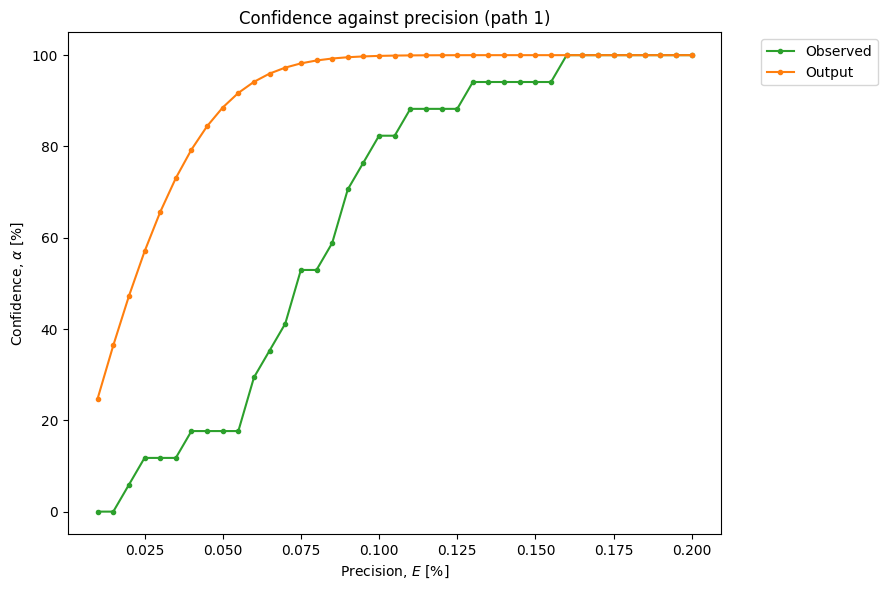

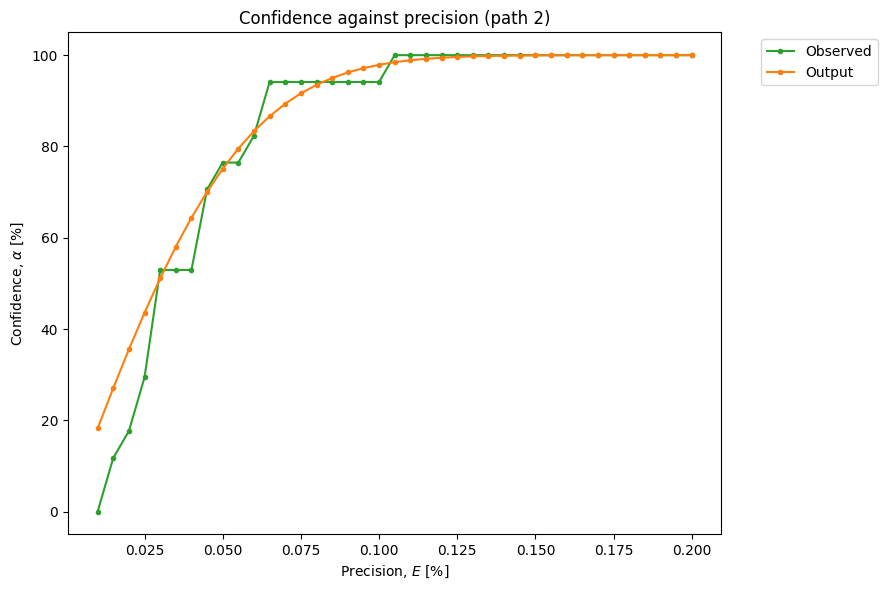

In [38]:
# [PLOT] - confidence against prec
plt.figure(figsize=(9, 6))
plt.title("Confidence against precision (path 1)")
plt.xlabel("Precision, $E$ [%]")
plt.ylabel("Confidence, $\\alpha$ [%]")
# plt.xlim(left=-0.0001, right=0.005)
plt.plot([p * 100 for p in precisions], observed_confidences1, label="Observed", color="tab:green", marker=".")
plt.plot([p * 100 for p in precisions], output_confidences1, label="Output", color="tab:orange", marker=".")

print([p * 100 for p in precisions])
print(output_confidences1)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.figure(figsize=(9, 6))
plt.xlabel("Precision, $E$ [%]")
plt.ylabel("Confidence, $\\alpha$ [%]")
plt.title("Confidence against precision (path 2)")
plt.plot([p * 100 for p in precisions], observed_confidences2, label="Observed", color="tab:green", marker=".")
plt.plot([p * 100 for p in precisions], output_confidences2, label="Output", color="tab:orange", marker=".")

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [106]:
def data_precision(data, confidence_level):
    # Convert the input data to a numpy array
    data = np.array(data)
    # Calculate the standard error of the mean (SEM)
    sem = st.sem(data)
    # Determine the size of the dataset
    n = len(data)
    # Calculate the margin of error
    margin_of_error = sem * st.t.ppf((1 + confidence_level) / 2., n-1)
    return margin_of_error 

In [107]:
# [EXPERIMENT] [FINAL SETTINGS] - check if confidence level  correct

confidences = [(90 + c / 2) / 100 for c in range(20)]
runs = 50

observed_precisions1 = []
observed_precisions2 = []
output_precisions1 = []
output_precisions2 = []


ll1 = 0.001
ll2 = 0.002

for c in confidences:
    # c = confidences[i]
    phat1s = []
    phat2s = []

    c_prec1s = []
    c_prec2s = []

    o_prec1s = []
    o_prec2s = []

    sync_data, _ = use_old_data(20, 20, ll1, ll2, 0.01, 40, tcp_flows=20, loss_duration=0.5, delete=False)
    for results in sync_data:
        n = results["n"]
        rtx1 = results["rtx1"]
        rtx2 = results["rtx2"]
        phat1 = rtx1 / n
        phat2 = rtx2 / n

        phat1s.append(phat1)
        phat2s.append(phat2)

        c_prec1s.append(get_precision(n, c, phat1))
        c_prec2s.append(get_precision(n, c, phat2))

        o_prec1s.append(phat1 - ll1)
        o_prec2s.append(phat2 - ll2)


    observed_precisions1.append(data_precision(o_prec1s, c) * 100)
    observed_precisions2.append(data_precision(o_prec1s, c) * 100)

    output_precisions1.append(np.mean(c_prec1s) * 100)
    output_precisions2.append(np.mean(c_prec2s) * 100)

[0.01, 0.015, 0.02, 0.025, 0.03, 0.034999999999999996, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.06999999999999999, 0.075, 0.08, 0.08499999999999999, 0.09, 0.095, 0.1, 0.105, 0.11, 0.11499999999999999, 0.12, 0.125, 0.13, 0.135, 0.13999999999999999, 0.145, 0.15, 0.155, 0.16, 0.165, 0.16999999999999998, 0.17500000000000002, 0.18, 0.185, 0.19, 0.19499999999999998, 0.2]
[90.0, 90.50000000000001, 90.99999999999999, 91.5, 92.00000000000001, 92.49999999999999, 93.0, 93.50000000000003, 93.99999999999997, 94.5, 95.00000000000001, 95.49999999999999, 96.0, 96.50000000000001, 96.99999999999999, 97.5, 98.0, 98.5, 99.00000000000001, 99.49999999999999]


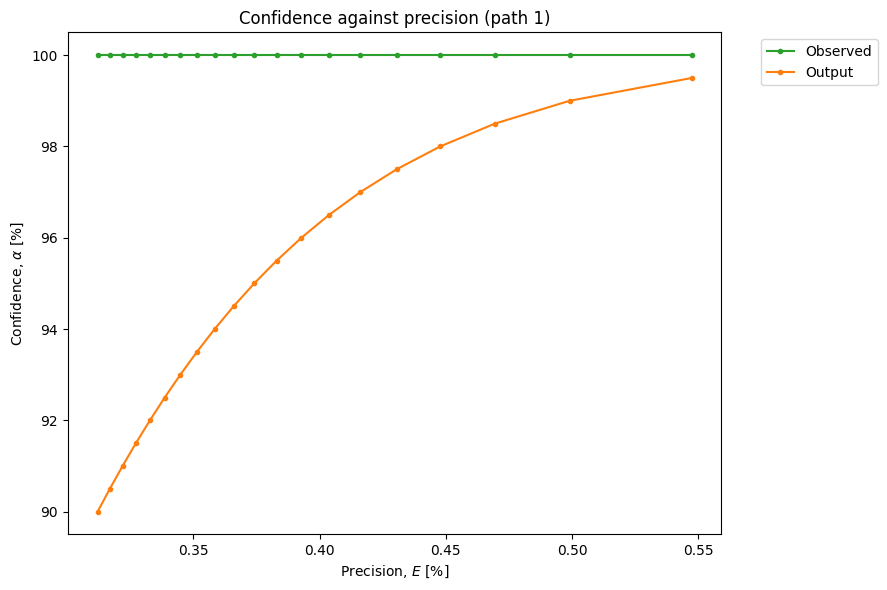

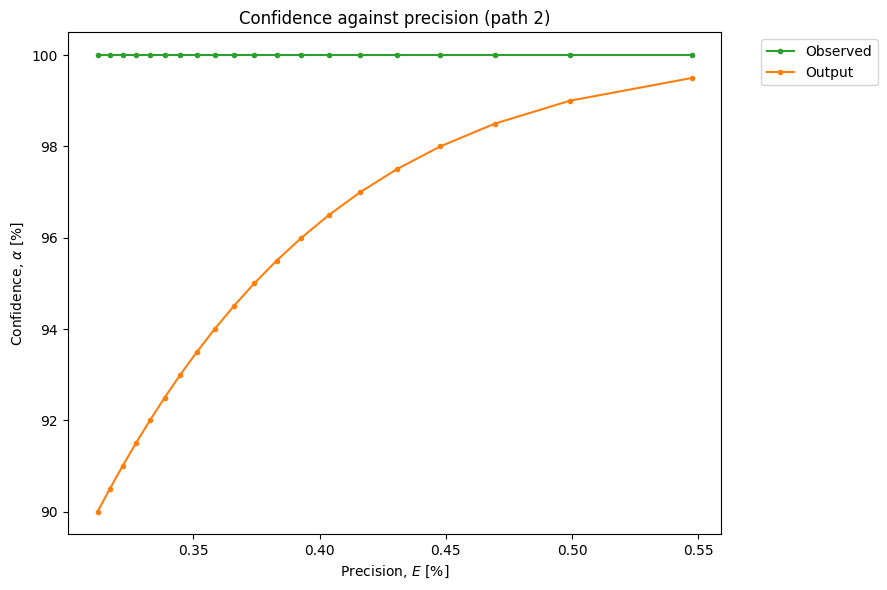

In [76]:
# [PLOT] - confidence against prec
plt.figure(figsize=(9, 6))
plt.title("Confidence against precision (path 1)")
plt.xlabel("Precision, $E$ [%]")
plt.ylabel("Confidence, $\\alpha$ [%]")
# plt.xlim(left=-0.0001, right=0.005)
plt.plot([p * 100 for p in observed_precisions1], observed_confidences1, label="Observed", color="tab:green", marker=".")
plt.plot([p * 100 for p in observed_precisions1], output_confidences1, label="Output", color="tab:orange", marker=".")

print([p * 100 for p in precisions])
print(output_confidences1)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.figure(figsize=(9, 6))
plt.xlabel("Precision, $E$ [%]")
plt.ylabel("Confidence, $\\alpha$ [%]")
plt.title("Confidence against precision (path 2)")
plt.plot([p * 100 for p in observed_precisions2], observed_confidences2, label="Observed", color="tab:green", marker=".")
plt.plot([p * 100 for p in observed_precisions2], output_confidences2, label="Output", color="tab:orange", marker=".")

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

min max output 1
0.019227080096474333
0.03281207653563871
min max observed 1
0.0031216356089991274
0.005473597805039721
min max output 2
0.022746980126390846
0.03881898078734545
min max observed 2
0.0031216356089991274
0.005473597805039721


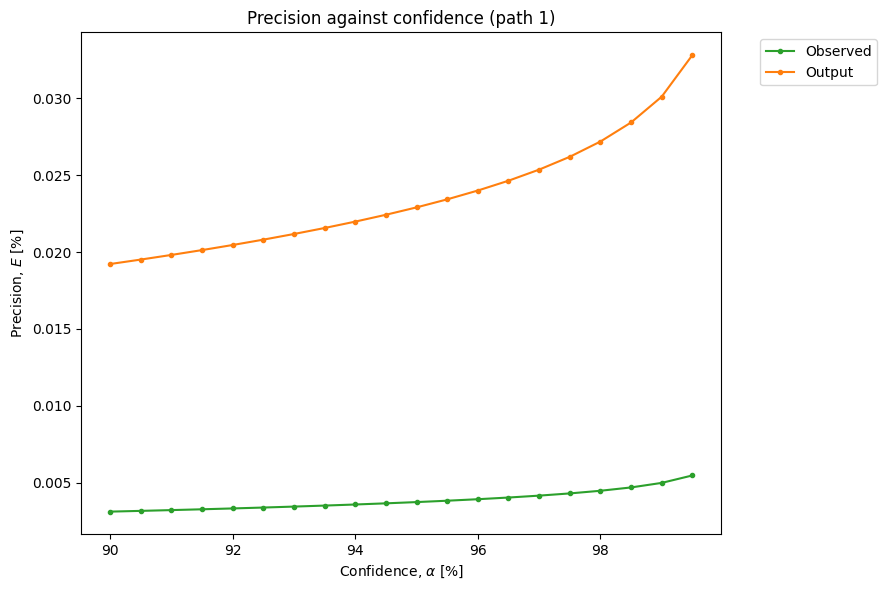

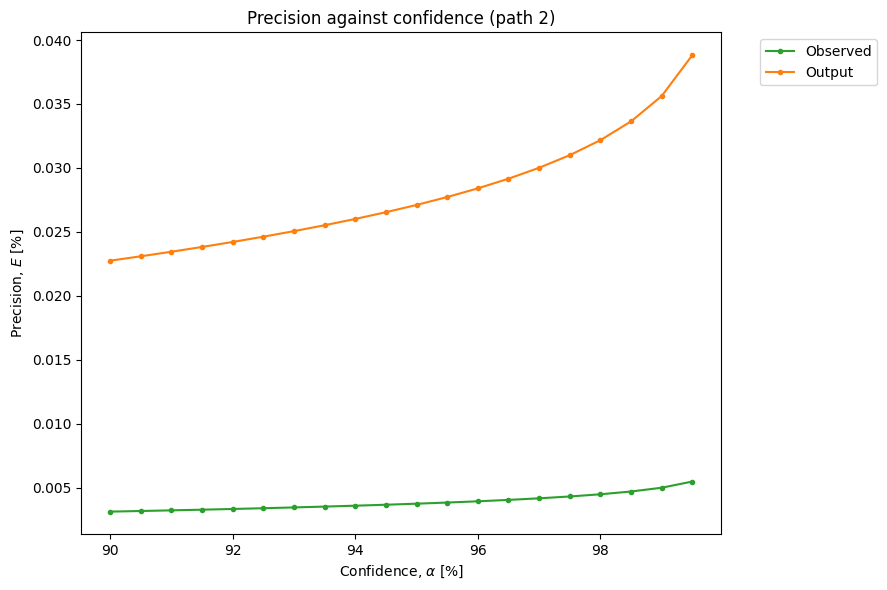

In [97]:
print("min max output 1")
print(min(output_precisions1) )
print(max(output_precisions1) )

print("min max observed 1")

print(min(observed_precisions1) )
print(max(observed_precisions1) )

print("min max output 2")

print(min(output_precisions2) )
print(max(output_precisions2) )
print("min max observed 2")
print(min(observed_precisions2) )
print(max(observed_precisions2) )


plt.figure(figsize=(9, 6))
plt.title("Precision against confidence (path 1)")
plt.xlabel("Confidence, $\\alpha$ [%]")
plt.ylabel("Precision, $E$ [%]")
plt.plot([c * 100 for c in confidences], observed_precisions1, label="Observed",  color="tab:green", marker=".")
plt.plot([c * 100 for c in confidences], output_precisions1, label="Output",  color="tab:orange", marker=".")

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.figure(figsize=(9, 6))
plt.title("Precision against confidence (path 2)")
plt.xlabel("Confidence, $\\alpha$ [%]")
plt.ylabel("Precision, $E$ [%]")
plt.plot([c * 100 for c in confidences], observed_precisions2, label="Observed",  color="tab:green", marker=".")
plt.plot([c * 100 for c in confidences], output_precisions2, label="Output",  color="tab:orange", marker=".")


plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [8]:
# [EXPERIMENT DATA] - time unbound check time

alpha = 0.95
E = 0.001
ll1 = 0.01
ll2 = 0.02
delta = 0.01
required_times = []



In [32]:
precision_times = []
advice_precision_times = []
precisions = [p / 20000 for p in range(20, 101, 10)]
init_time = 120

runs=0

for p in precisions:

    ps = []

    data = use_time_unbound_data(20, 20, ll1, ll2, delta, tcp_flows=20, loss_duration=0, alpha=alpha, E=p, delete=True)
    for j in range(max(runs, len(data))):
        if len(data) <= j:
            return_dict = time_unbound_mode(20, 20, ll1, ll2, delta, seconds=init_time, tcp_flows=20, E=p, alpha=alpha, loss_duration=0)
        else:
            return_dict = data[j]

        ps.append(return_dict["time"])
        init_time = return_dict["time"]+20

    precision_times.append(np.mean(ps))
    advice_precision_times.append(advice_run_test_time(alpha, p, 5000, 5000, delta, max_phat=0.2))
    print("done for {} runs ".format(len(ps)),  p)


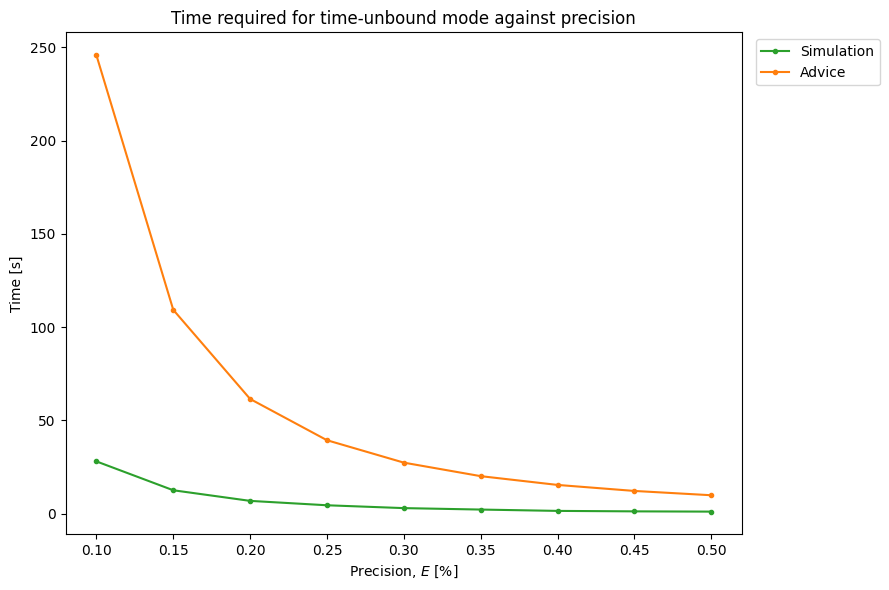

In [27]:



plt.figure(figsize=(9, 6))
plt.ylabel("Time [s]")
plt.xlabel("Precision, $E$ [%]")
plt.title("Time required for time-unbound mode against precision")
plt.plot([p * 100 for p in precisions], precision_times, label="Simulation", color="tab:green", marker=".")
plt.plot([p * 100 for p in precisions], advice_precision_times, label="Advice",  color="tab:orange", marker=".")


plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tight_layout()


In [33]:
confidence_times = []
advice_confidence_times = []
confidences = [c / 100 for c in range(90, 100)]

runs = 0

for c in confidences:

    cs = []

    data = use_time_unbound_data(20, 20, ll1, ll2, delta, tcp_flows=20, loss_duration=0, alpha=c, E=E, delete=True)
    for j in range(max(runs, len(data))):
        if len(data) <= j:
            return_dict = time_unbound_mode(20, 20, ll1, ll2, delta, seconds=init_time, tcp_flows=20, E=E, alpha=c, loss_duration=0)
        else:
            return_dict = data[j]

        # results = time_unbound_mode(20, 20, delta, ll1, ll2, p, alpha, tcpFlows=20, seconds=init_time)
        cs.append(return_dict["time"])
        init_time = return_dict["time"]+20

    confidence_times.append(np.mean(cs))
    advice_confidence_times.append(advice_run_test_time(c, E, 5000, 5000, delta, max_phat=0.2))
    print("done for {} runs ".format(len(cs)),  c)


47.8096
27.9894


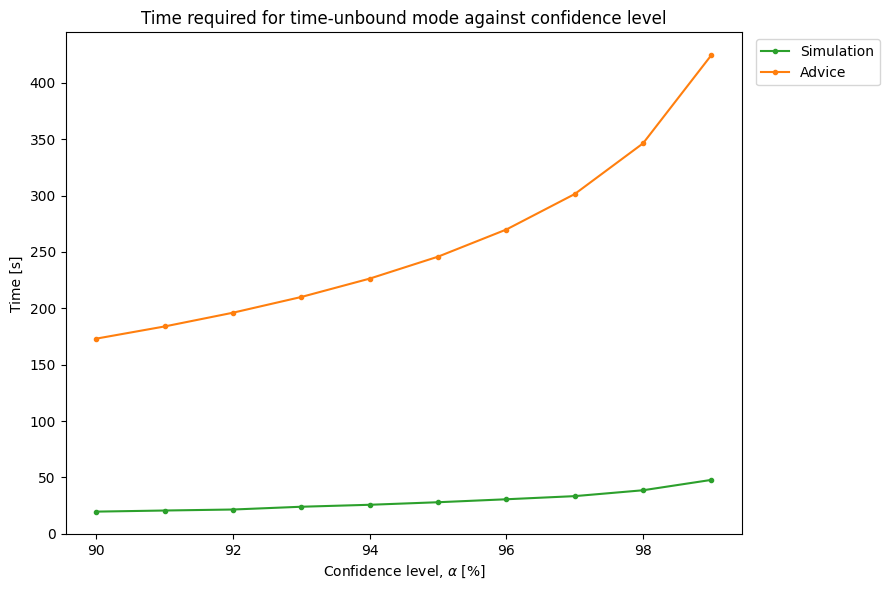

In [26]:


plt.figure(figsize=(9, 6))
plt.ylabel("Time [s]")
plt.xlabel("Confidence level, $\\alpha$ [%]")
plt.title("Time required for time-unbound mode against confidence level")

plt.plot([c * 100 for c in confidences], confidence_times, label="Simulation", color="tab:green", marker=".")
plt.plot([c * 100 for c in confidences], advice_confidence_times, label="Advice",  color="tab:orange", marker=".")
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tight_layout()

print(max(confidence_times))
print(max(precision_times))